# Companies that are part of the AEX Index
[The AEX index](https://en.wikipedia.org/wiki/AEX_index#cite_note-12) is a capitalization-weighted index composed of 25 large capitalization Dutch companies that trade on Euronext Amsterdam.

In this notebook I look at:
* the market capitalization of listed domestic companies that are part of the Stoxx Europe 600 Banks index
* the total annual and daily value of stocks traded that belong to the index
* the annual and daily turover rations of stocks traded that belong to the index
* the forward annual dividend yield of banks that are part of the index
* the forward price to earnings ratio of banks that are part of the index
* the P/B and ROEs of banks that are part of the index and their cost of equity

I created my own module called `stock_market.metrics` (which is part of this repository) where I calculate capitalization, turnover, forward dividend yields and volatility of an arbitrary stock market with the help of the [yfinance](https://pypi.org/project/yfinance/) module. I use it to provide metrics on companies that are part of the AEX Index.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/US_Economic_Data_Analysis.git cloned-repo
#%cd cloned-repo

# Install the latest version of pandas-datareader and yfinance
# !pip install pandas-datareader -U
# !pip install yfinance -U
# !pip install eurostat -U

In [2]:
import pandas as pd
from pandas.tseries.offsets import YearBegin
import numpy as np
import scipy
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from pandas_datareader import wb
import eurostat

from datetime import date

from stock_market import metrics

In [3]:
# Human readable column names for DataFrames
MKT_CAP_AEX = 'Market capitalization of AEX companies'
MKT_CAP_TOP10_AEX = 'Top-10 AEX companies by market capitalization and their share of AEX'
TRAD_VOL = 'Stocks traded, total value'
TRAD_VOL_AEX_GRAPH_TITLE = 'AEX ' + TRAD_VOL + ' (annualized)'
TRAD_VOL_AEX_GRAPH_TITLE_DAILY = 'AEX ' + TRAD_VOL + ' (average daily)'
TUROVER_RATIO_AEX = 'Turnover ratio of AEX companies shares (%)'
TUROVER_RATIO_AEX_GRAPH_TITLE = 'Stocks traded, Annual ' + TUROVER_RATIO_AEX
TUROVER_RATIO_AEX_DAILY_GRAPH_TITLE = 'Stocks traded, Daily ' + TUROVER_RATIO_AEX
EXCESS_RETURN_AEX = 'Excess Annual Return of AEX over 1-year Riskless rate'

# Y axis labels for graphs
LEFT_Y_AXIS_LABEL = 'Billions of Euros'

TTM_SUFFIX = ' (ttm)'
MRQ_SUFFIX = ' (mrq)'

In [4]:
start = date(2022, 1, 1)
aex_components = metrics.NLStockMarketMetrics.get_aex_historical_components(start)
aex_metrics = metrics.NLStockMarketMetrics(aex_components, start=start)

[*********************100%***********************]  28 of 28 completed


Correcting the number of shares outstanding for EXO.AS from 316615008 to 201503008


[*********************100%***********************]  1 of 1 completed


In [5]:
# A look-up map from ticker symbols to displayable names
names = aex_metrics.tickers_to_display_names(aex_components)
ticker_to_name = dict(zip(aex_components, names))

In [6]:
# Convert into billions of Euros
aex_capitalization = aex_metrics.get_capitalization(frequency='MS') / 1e9
aex_annual_trading_value = aex_metrics.get_annual_trading_value(frequency='MS') / 1e9
aex_daily_trading_value = aex_metrics.get_daily_trading_value(frequency='MS') / 1e9

aex_daily_turnover = aex_metrics.get_daily_turnover(frequency='MS')
aex_annual_turnover = aex_metrics.get_annual_turnover(frequency='MS')

In [7]:
stock_mkt_aex = pd.concat([aex_capitalization, aex_annual_trading_value, aex_daily_turnover], axis=1)
stock_mkt_aex.columns = [MKT_CAP_AEX, TRAD_VOL, TUROVER_RATIO_AEX]
stock_mkt_aex.dropna(inplace=True)

In the below table **_Stocks traded, total value_** represents a cumulative annual amount of all transactions in shares of companies in the AEX. **_Turnover ratio of AEX components_** represents the percentage of shares outstanding that are traded per day.

In [8]:
pd.options.display.float_format = (lambda x: '{:.2%}'.format(x) if x < 5 else '€{:,.2f}bn'.format(x))
pd.options.display.max_rows = 40
stock_mkt_aex

,Market capitalization of AEX companies,"Stocks traded, total value",Turnover ratio of AEX companies shares (%)
Date,,,
2022-01-01,"€1,233.96bn",€694.20bn,0.22%
2022-02-01,"€1,125.99bn",€709.70bn,0.25%
2022-03-01,"€1,059.18bn",€777.16bn,0.29%
2022-04-01,"€1,066.68bn",€557.98bn,0.21%
2022-05-01,"€1,024.43bn",€554.85bn,0.21%
...,...,...,...
2025-03-01,"€1,248.94bn",€626.81bn,0.20%
2025-04-01,"€1,159.75bn",€642.54bn,0.22%
2025-05-01,"€1,241.58bn",€485.99bn,0.16%


## Market capitalization of companies in the AEX index

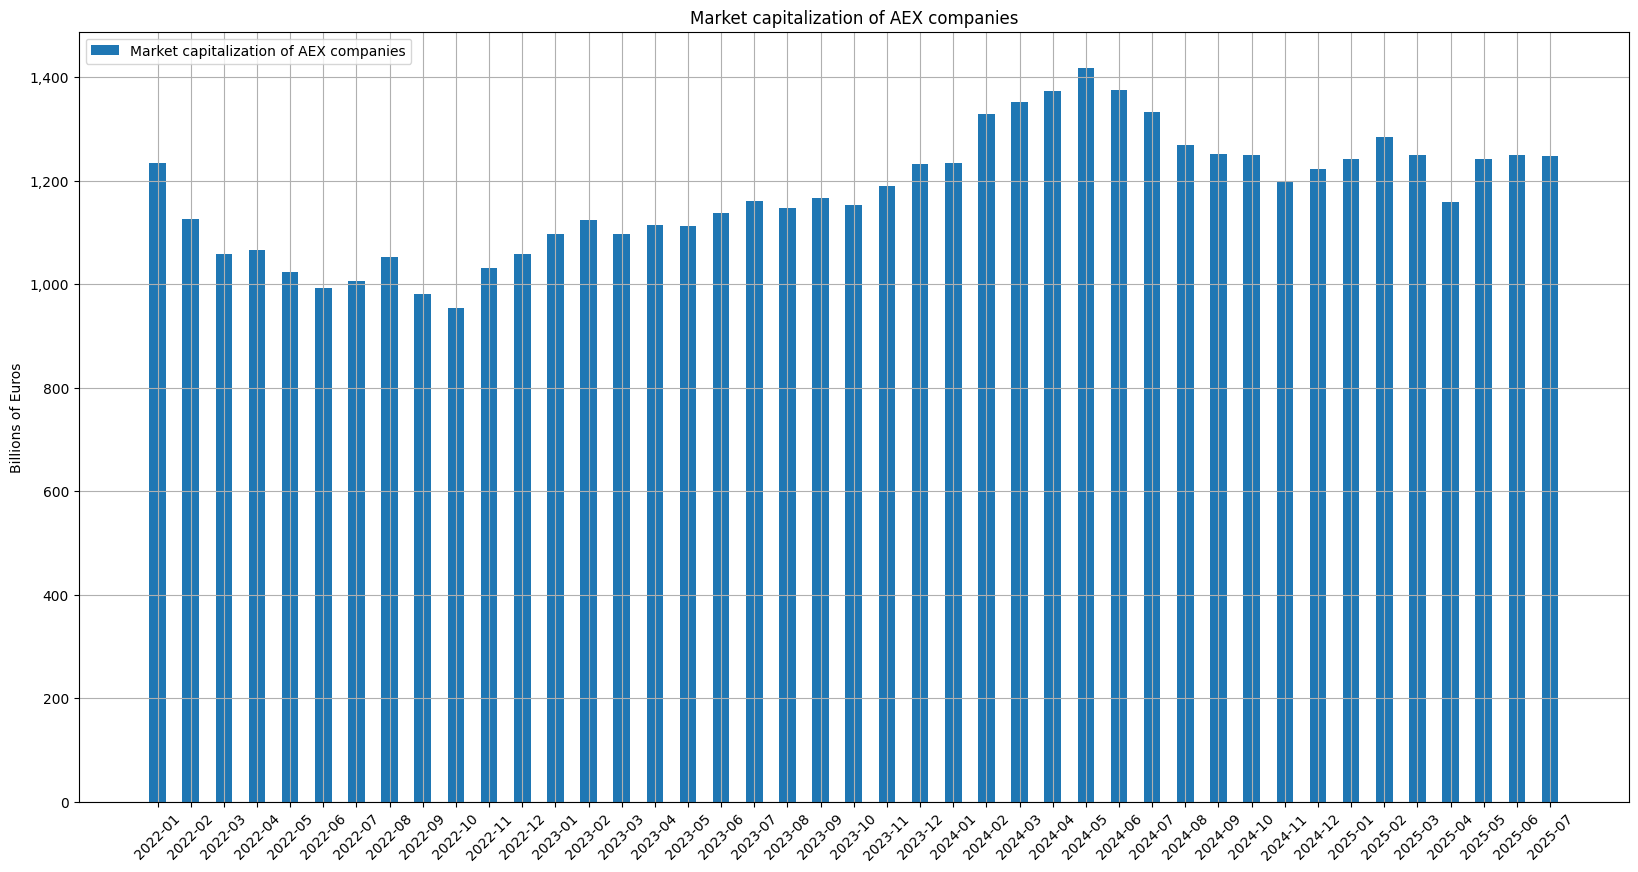

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x=range(len(stock_mkt_aex)), height=stock_mkt_aex.iloc[:,0], color='#1f77b4', width=0.5,
       label=MKT_CAP_AEX)
ax.legend(loc='upper left')
ax.title.set_text(MKT_CAP_AEX)
ax.grid(True)
_ = ax.set_xticks(range(len(stock_mkt_aex)), stock_mkt_aex.index)
_ = ax.set_xticklabels(stock_mkt_aex.index.strftime('%Y-%m'), rotation=45)
#ax.set_yticks(np.arange(0, 56000, 5000))
ax.set_ylabel(LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')

### Top-10 banks  by their capitalization and their share in the overall capitalization of AEX companies

In [10]:
top10_today = aex_metrics.get_top_n_capitalization_companies_for_day(
    10, merge_additional_share_classes=True)
top10_last_month = aex_metrics.get_top_n_capitalization_companies_for_month(
    10, aex_metrics.data.index[-1] - pd.DateOffset(months=+1))
top10_year_ago = aex_metrics.get_top_n_capitalization_companies_for_month(
    10, aex_metrics.data.index[-1] - pd.DateOffset(months=+12))

# Calculate metrics for the previous 3 years
num_years = 3
years = list(range(aex_metrics.data.index[-1].year-num_years, aex_metrics.data.index[-1].year))
top10_last_n_years = [aex_metrics.get_top_n_capitalization_companies_for_year(10, date(year, 1, 1)) for year in years]

In [11]:
# Convert into Billions of Euros
top10 = list(map(lambda df: df.Capitalization, top10_last_n_years))
top10.append(top10_today.Capitalization)
top10 = pd.concat(top10, axis=1) / 1e9
columns = [aex_metrics.CAPITALIZATION + f' in {year}' for year in years]
columns.append(' now')
top10.columns = columns

top10_pct = list(map(lambda df: df.iloc[:,1], top10_last_n_years))
top10_pct.append(top10_today.iloc[:,1])
top10_pct = pd.concat(top10_pct, axis=1)

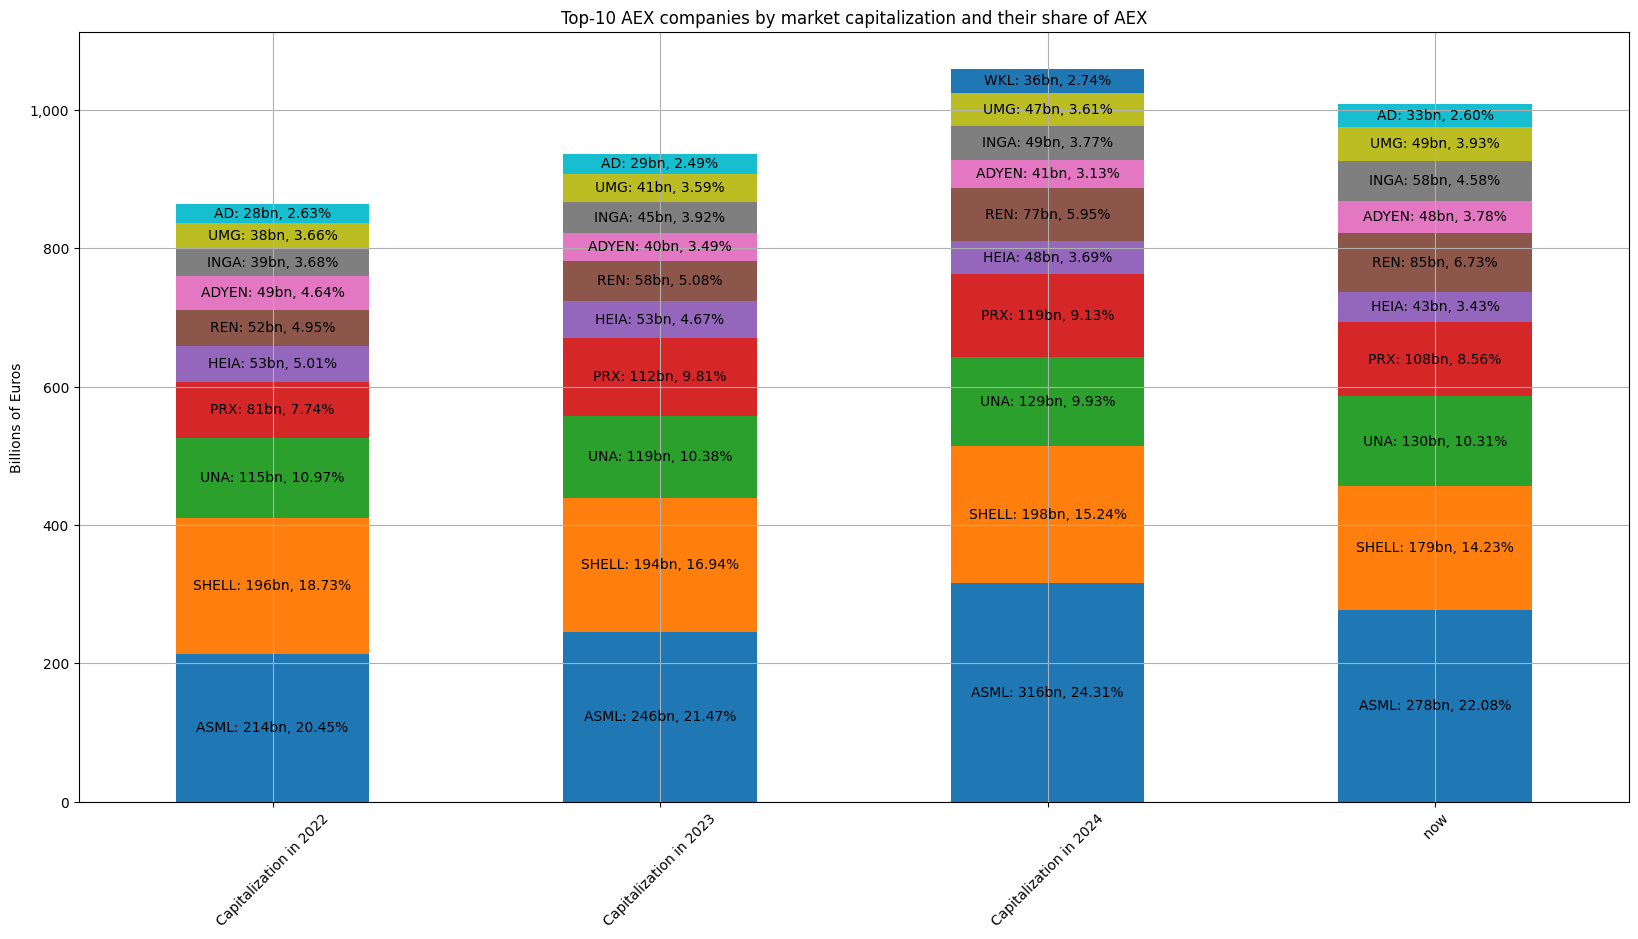

In [12]:
ax = top10.T.plot.bar(figsize=(20,10), grid=True, title=MKT_CAP_TOP10_AEX,
                      stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.get_legend().remove()
for c in ax.containers:
    labels = [c.get_label().split('.')[0] + f': {a:,.0f}bn, {top10_pct.loc[c.get_label()].iloc[i]:.2%}'
              if a else '' for i, a in enumerate(c.datavalues)]
    ax.bar_label(c, labels=labels, label_type="center")

### Capitalization: Last Business Day vs. Previous Month's Average

In [13]:
top10_now = pd.concat([top10_last_month.Capitalization, top10_today.Capitalization], axis=1) / 1e9
top10_now.columns = [aex_metrics.CAPITALIZATION + sfx for sfx in [' last month', ' now']]
top10_today_pct = pd.concat([top10_last_month.iloc[:,1], top10_today.iloc[:,1]], axis=1)

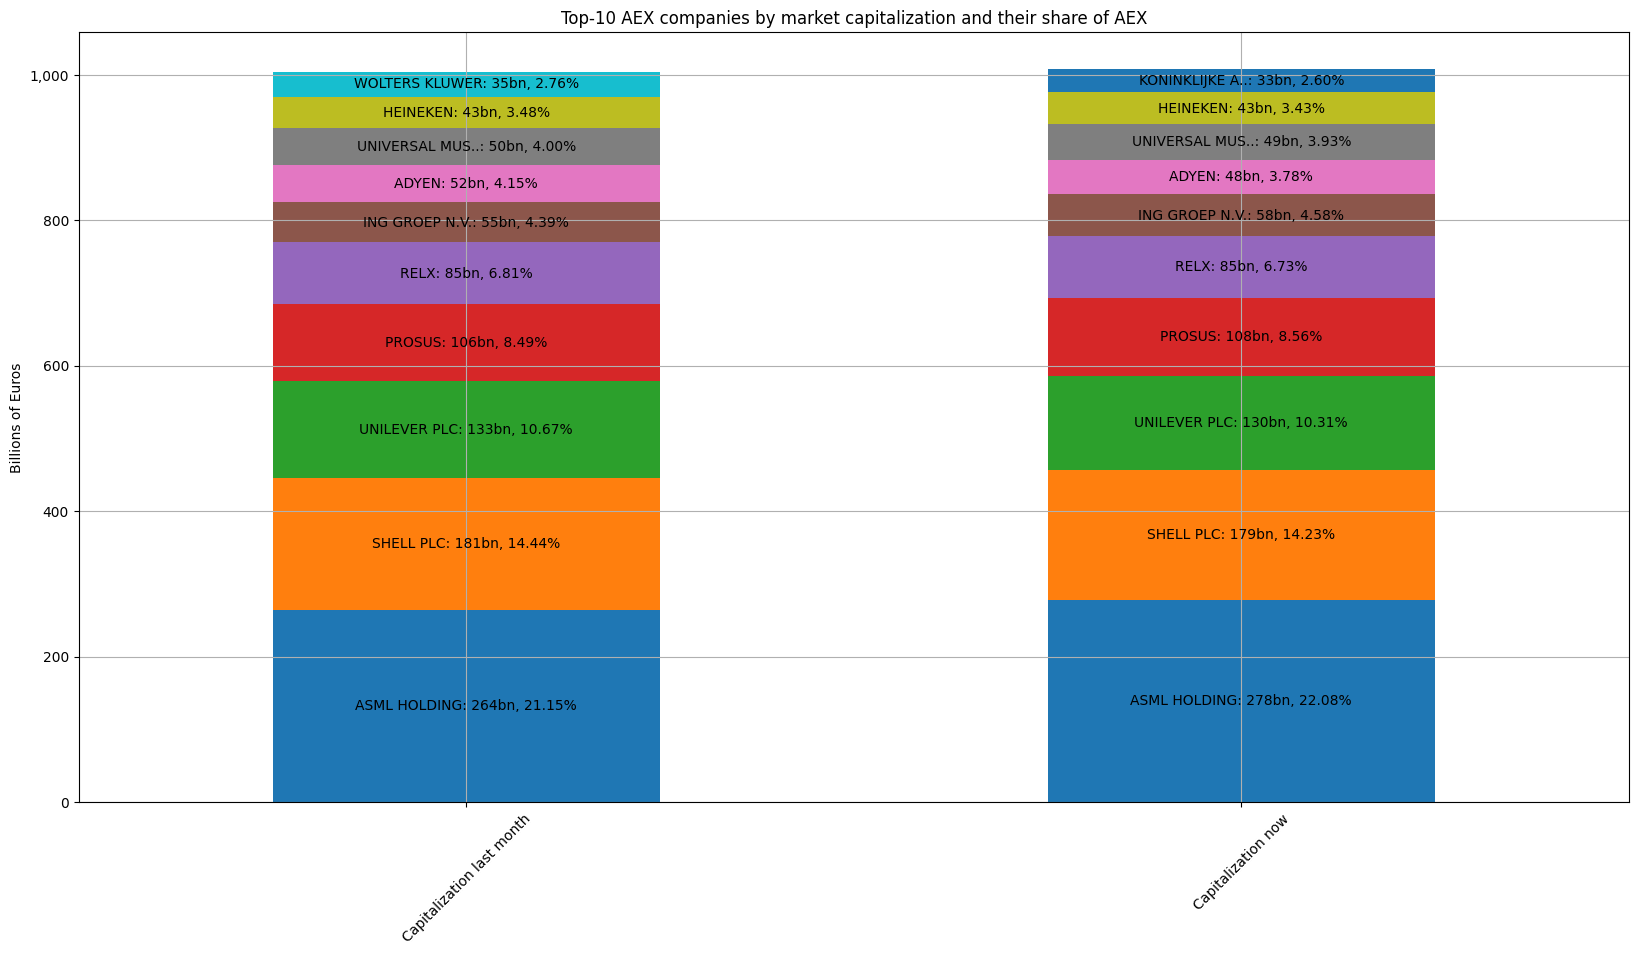

In [14]:
ax = top10_now.T.plot.bar(figsize=(20,10), grid=True, title=MKT_CAP_TOP10_AEX,
                          stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.get_legend().remove()
for c in ax.containers:
    labels = [ticker_to_name[c.get_label()] + f': {a:,.0f}bn, {top10_today_pct.loc[c.get_label()].iloc[i]:.2%}'
              if a else '' for i, a in enumerate(c.datavalues)]
    ax.bar_label(c, labels=labels, label_type="center")

### Capitalization: Last Business Day vs. Average from Same Month Last Year

In [15]:
top10_now = pd.concat([top10_year_ago.Capitalization, top10_today.Capitalization], axis=1) / 1e9
top10_now.columns = [aex_metrics.CAPITALIZATION + sfx for sfx in [' year ago', ' now']]
top10_today_pct = pd.concat([top10_year_ago.iloc[:,1], top10_today.iloc[:,1]], axis=1)

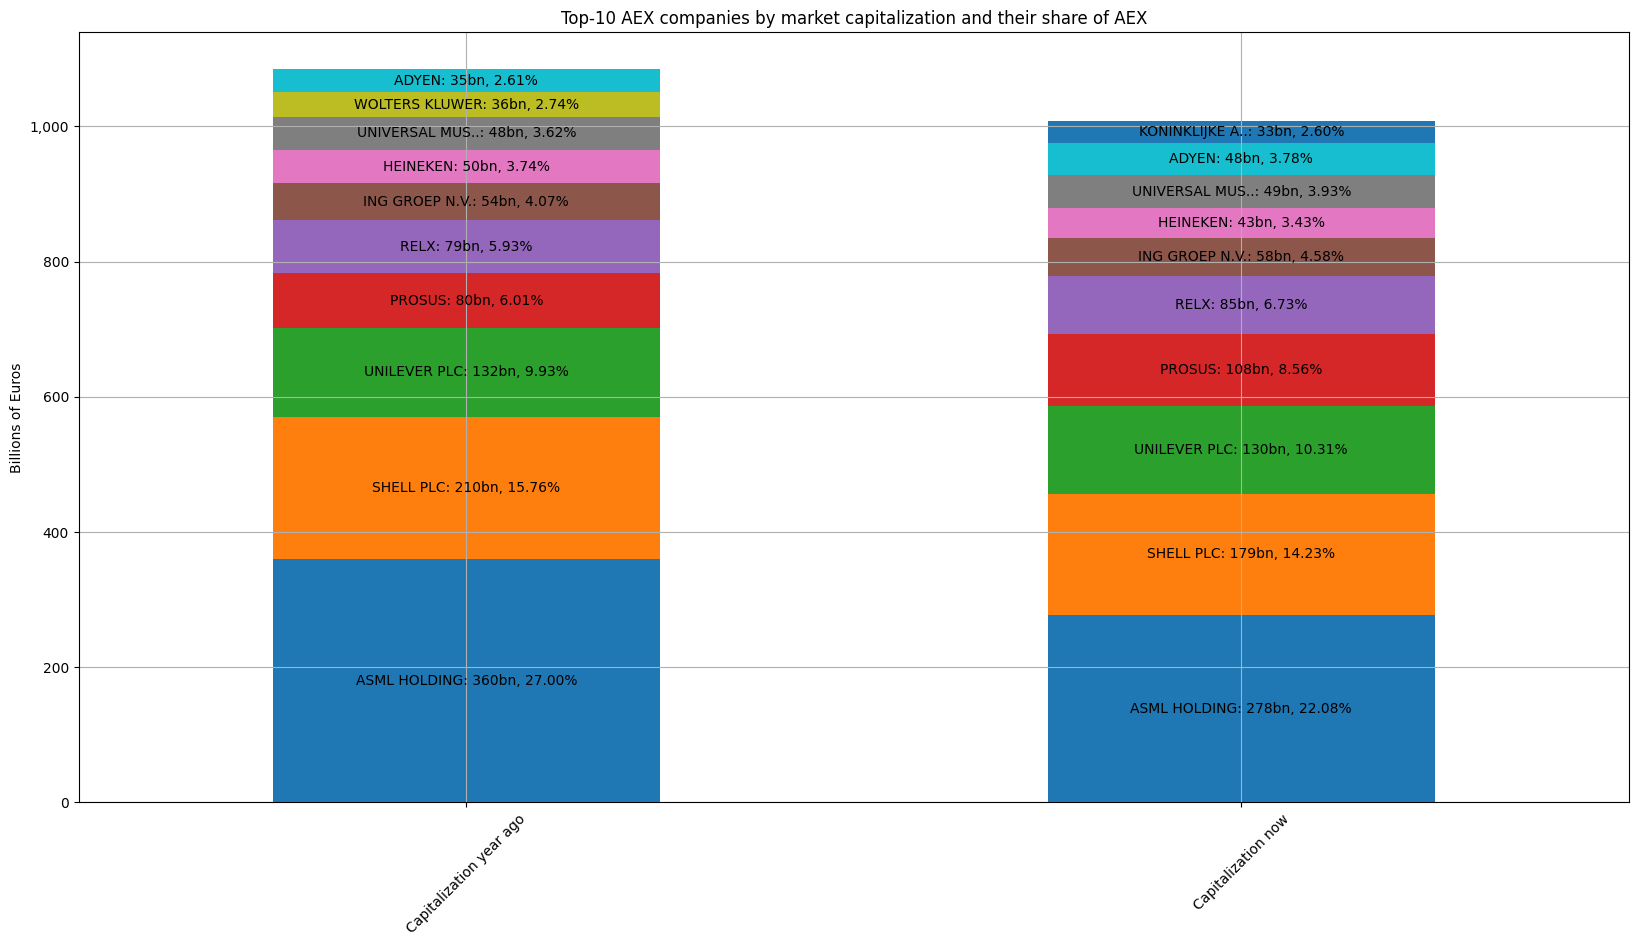

In [16]:
ax = top10_now.T.plot.bar(figsize=(20,10), grid=True, title=MKT_CAP_TOP10_AEX,
                          stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.get_legend().remove()
for c in ax.containers:
    labels = [ticker_to_name[c.get_label()] + f': {a:,.0f}bn, {top10_today_pct.loc[c.get_label()].iloc[i]:.2%}'
              if a else '' for i, a in enumerate(c.datavalues)]
    ax.bar_label(c, labels=labels, label_type="center")

In [17]:
print('The capitalization of Top-10 changed by '
      f'{(top10_today.Capitalization.sum()-top10_year_ago.Capitalization.sum())/top10_year_ago.Capitalization.sum():+.2%} from a year ago')

The capitalization of Top-10 changed by -7.09% from a year ago


In [18]:
print(f'The capitalization of AEX companies on {aex_metrics.capitalization.index[-1]:%Y-%m-%d} is '
      f'€{aex_metrics.capitalization.iloc[-1,0]/1e9:.3f}bn')

The capitalization of AEX companies on 2025-07-14 is €1256.897bn


In [19]:
dt_year_ago = pd.Timestamp((aex_metrics.data.index[-1] - pd.DateOffset(months=+12)).date().replace(day=1))
cap_year_ago = aex_capitalization.loc[dt_year_ago]
pct_change_over_year_all = (aex_metrics.capitalization.iloc[-1,0]/1e9 - cap_year_ago) / cap_year_ago
print(f'It changed by {pct_change_over_year_all:+.2%} from a year ago')
print(f'The capitalization of AEX companies in {dt_year_ago:%Y-%m} was €{cap_year_ago:.3f}bn')

It changed by -5.71% from a year ago
The capitalization of AEX companies in 2024-07 was €1333.019bn


## AEX's top-7 and their capitilization changes
Let's have a look at AEX's top-7 companies by capitalization and how it has been changing over the past few years

In [34]:
top7 = top10_now.iloc[:,1].sort_values(ascending=False).iloc[:7].index.to_list()

In [36]:
magn_seven = aex_metrics.get_capitalization_for_companies(top7, 'B')
magn_seven_cum_cap = magn_seven.iloc[:,1:].sum(axis=1)
print(f'The top Seven constituent companies in AEX make up '
      f'{magn_seven_cum_cap.iloc[-1]/magn_seven.iloc[-1,0]:.2%} of the index')
print(f'With a cumulative capitalization of €{magn_seven_cum_cap.iloc[-1]/1e12:.3f}trn')

The top Seven constituent companies in AEX make up 70.40% of the index
With a cumulative capitalization of €0.885trn


### Capitalization development of the top seven stocks since 2022

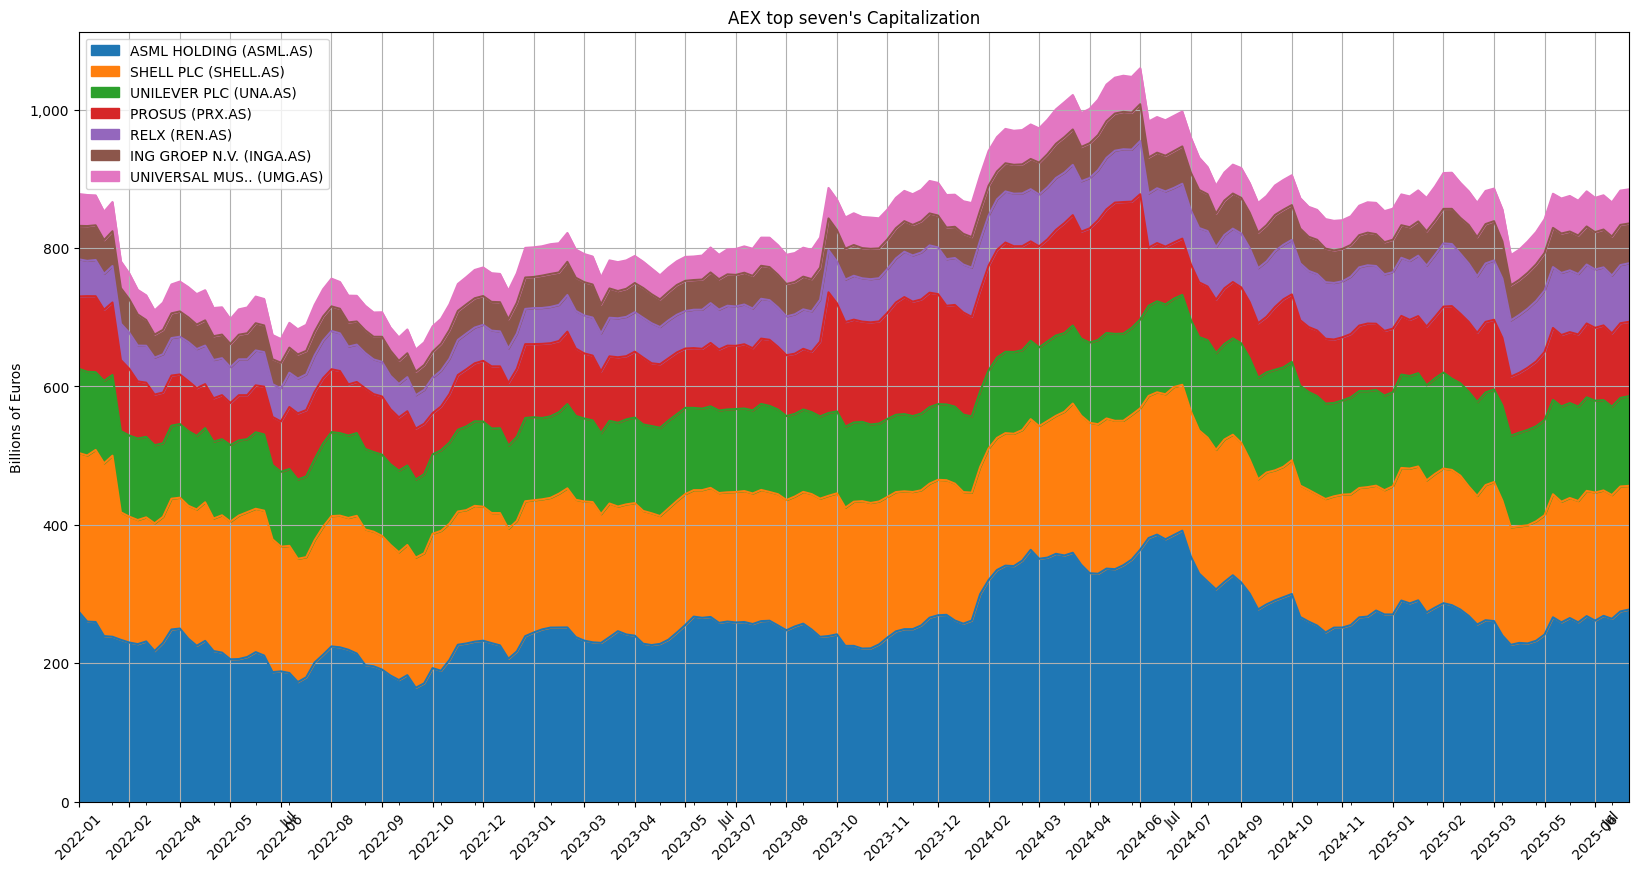

In [39]:
magn_seven_weekly = magn_seven.iloc[:,1:].resample('W').mean() / 1e9
magn_seven_weekly = magn_seven_weekly.loc[:, magn_seven_weekly.iloc[-1].sort_values(ascending=False).index]
ax = magn_seven_weekly.plot.area(figsize=(20,10), grid=True, title="AEX top seven's Capitalization",
                                 xticks=magn_seven_weekly.index[::6], xlabel='', rot=45,
                                 ylabel=LEFT_Y_AXIS_LABEL)
ax.legend(ax.collections, magn_seven_weekly.columns.map(lambda ticker: ticker_to_name[ticker] + f' ({ticker})'))
ax.yaxis.set_major_formatter('{x:,.0f}')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, magn_seven_weekly.index[::6])))

## Total annual and daily value of AEX companies' stocks traded 
For AEX companies I depict average daily trading values over each month. In the first graph I show average daily volumes per month, in the second I show average daily volues per month scaled to annual ammounts.

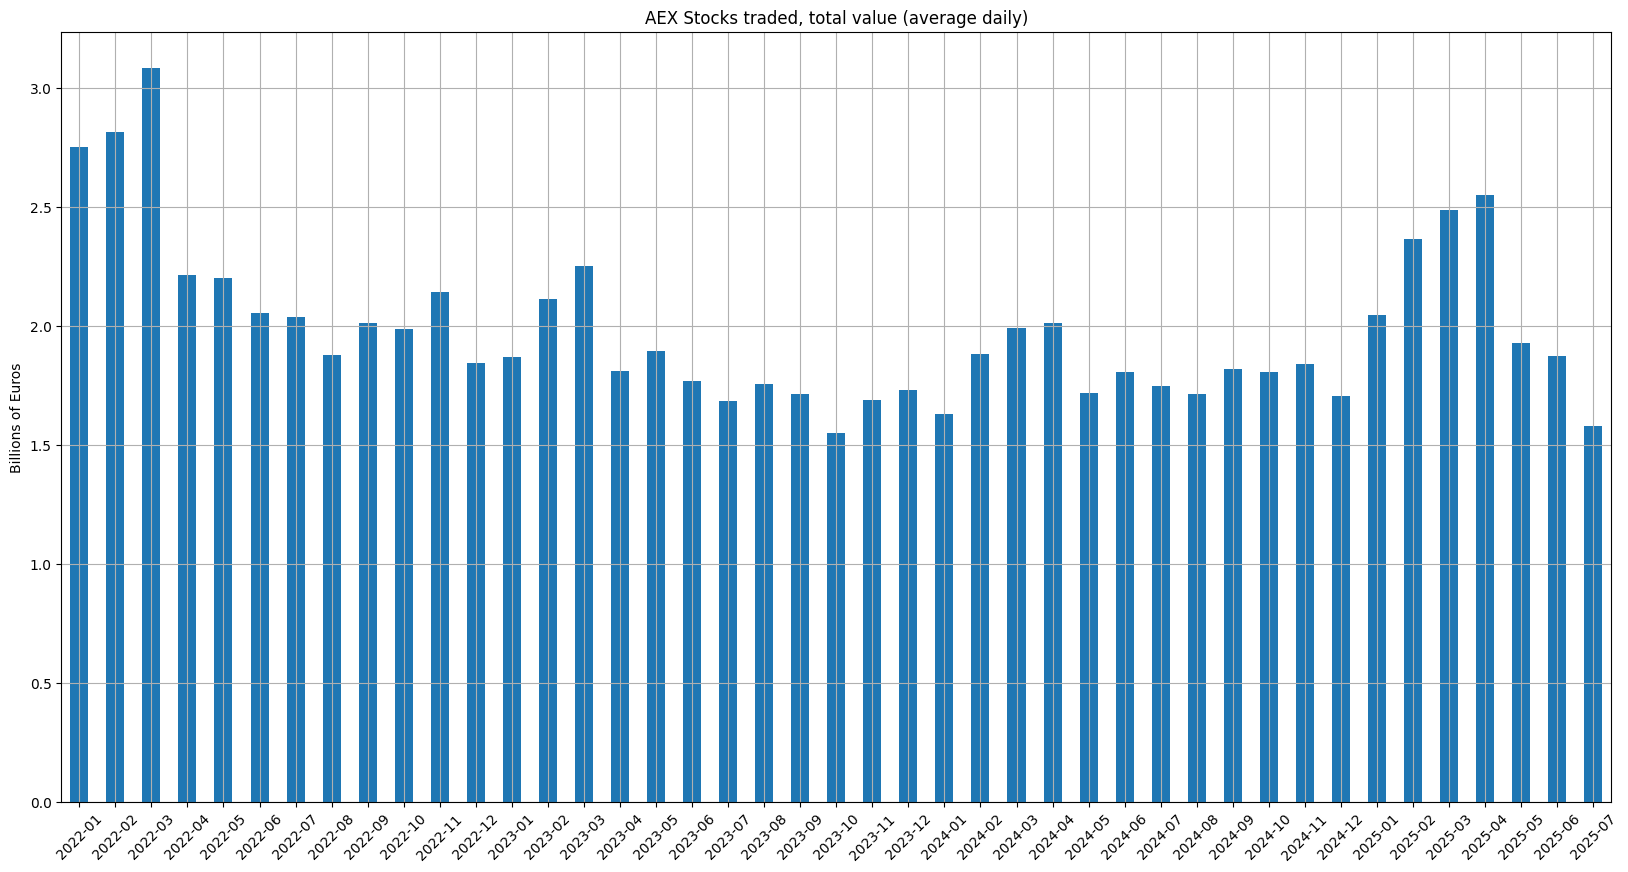

In [20]:
ax = aex_daily_trading_value.plot.bar(figsize=(20,10), grid=True, ylabel=LEFT_Y_AXIS_LABEL,
                                      title=TRAD_VOL_AEX_GRAPH_TITLE_DAILY, color='#1f77b4',
                                      xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, aex_daily_trading_value.index)))

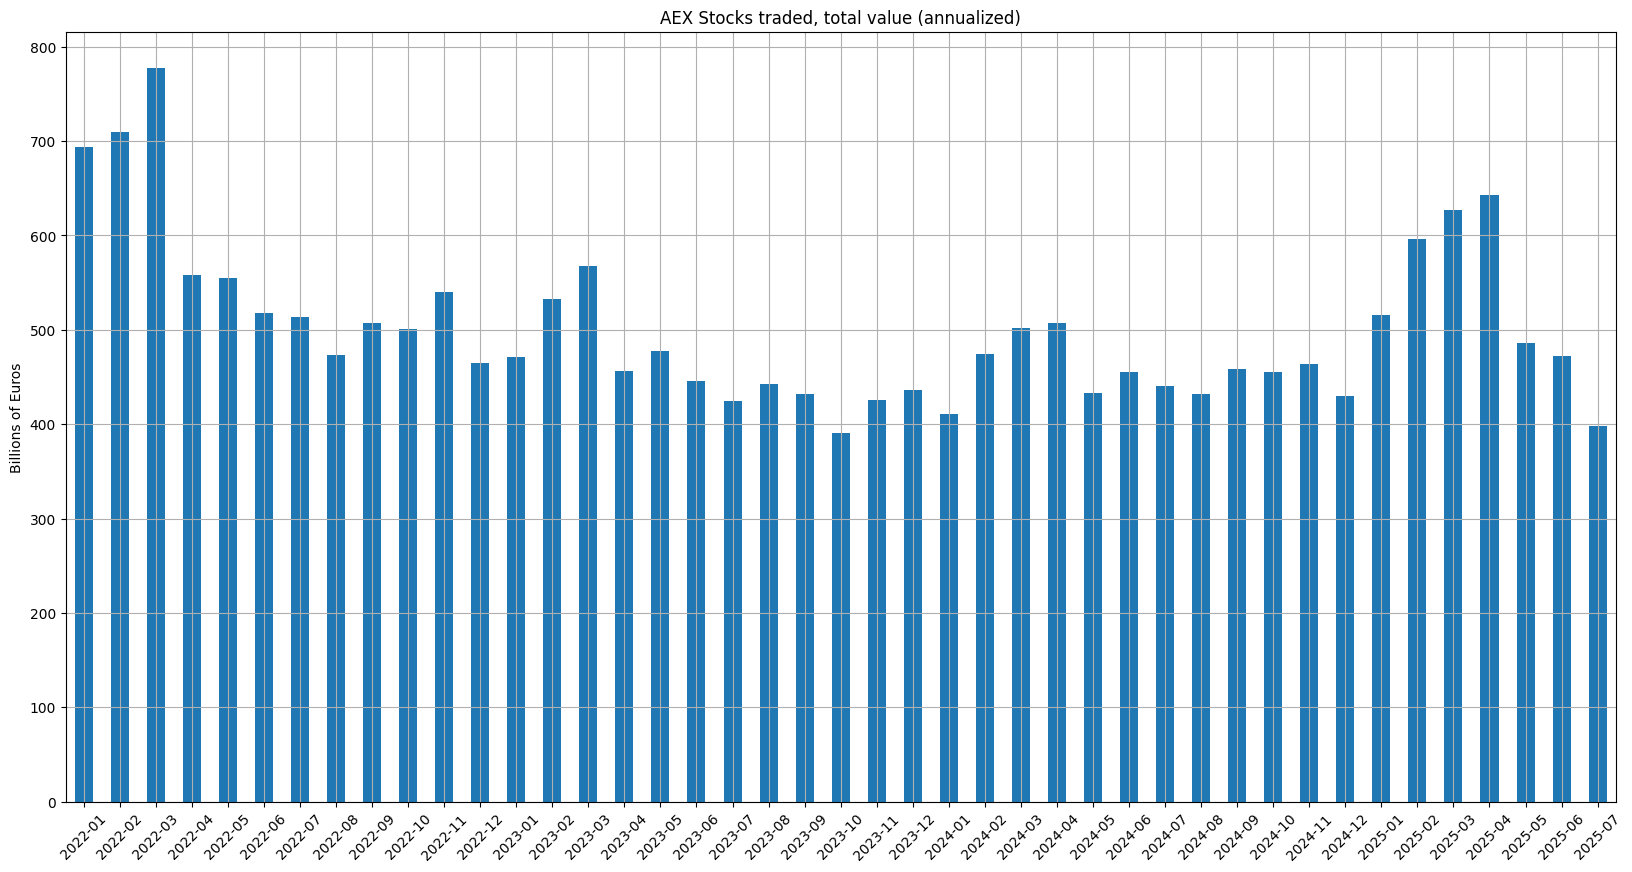

In [21]:
ax = aex_annual_trading_value.plot.bar(figsize=(20,10), grid=True, ylabel=LEFT_Y_AXIS_LABEL,
                                         title=TRAD_VOL_AEX_GRAPH_TITLE, color='#1f77b4',
                                         xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, aex_annual_trading_value.index)))

## Stocks traded, annual and daily turnover ratios of AEX companies' shares to their capitalization
In this section of the notebook I look at the turnover ratio of AEX companies' shares traded divided by their market capitalization. The value is annualized by multiplying the monthly average by 12.

If you divide the number for a given year by 252 (the approximate number of trading days), you obtain the percentage of shares that are traded in one day. This ranges between 0.2% and 1%. And such a small fraction of traded shares determine the capitalization of the whole firm.

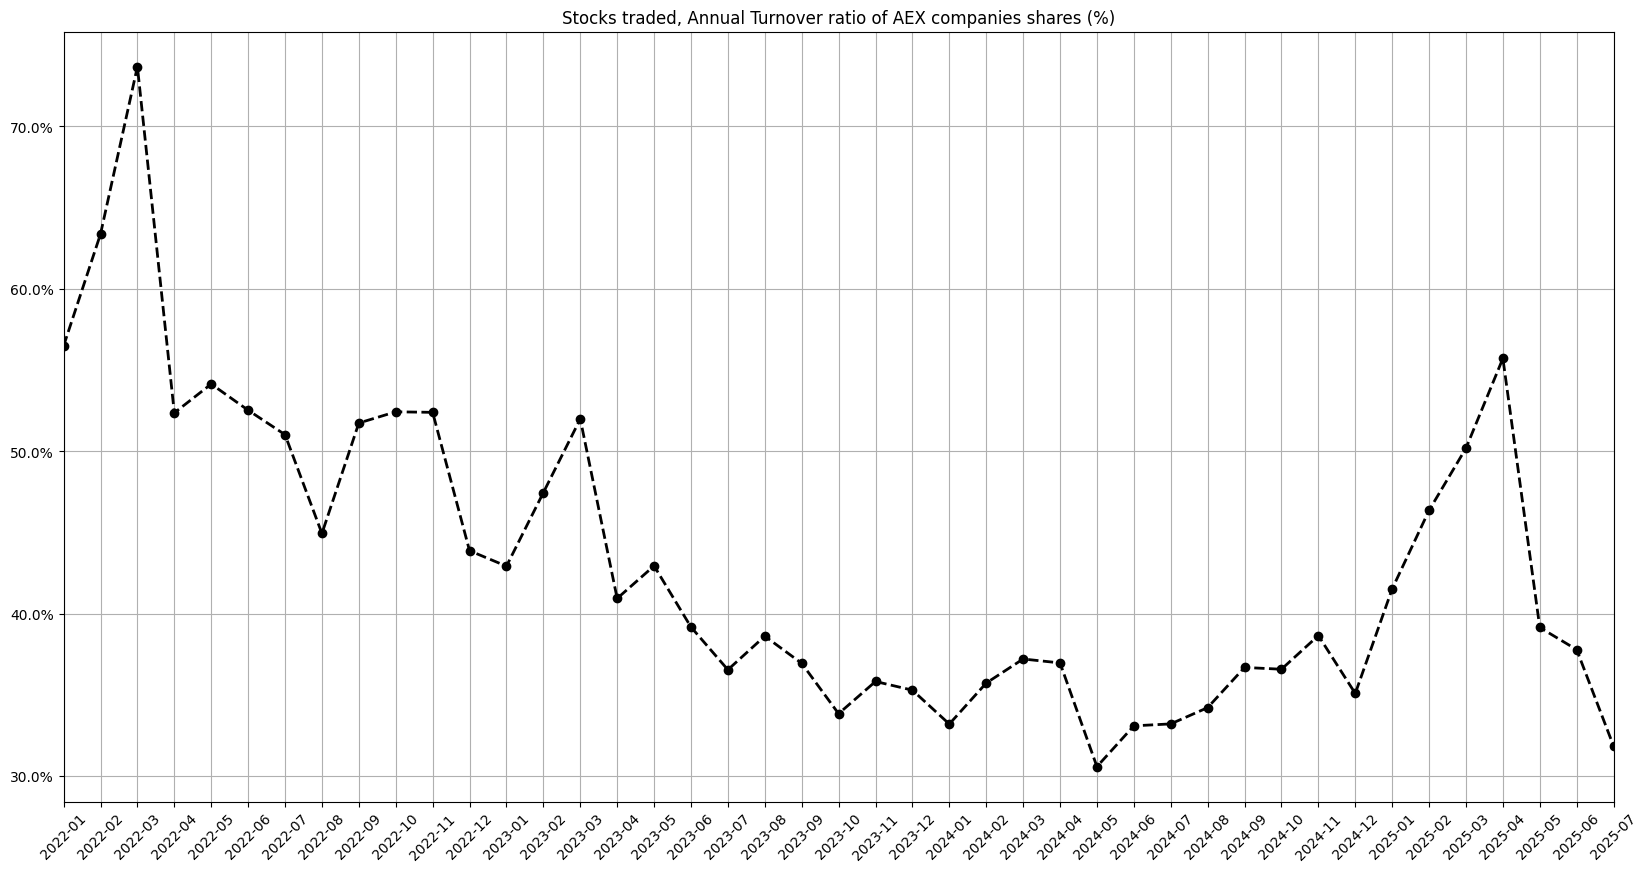

In [22]:
ax = aex_annual_turnover.dropna().plot(figsize=(20,10), grid=True, title=TUROVER_RATIO_AEX_GRAPH_TITLE,
                                       color='k', marker='o', linestyle='--', linewidth=2,
                                       xticks=aex_annual_turnover.index, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, aex_annual_turnover.index)))

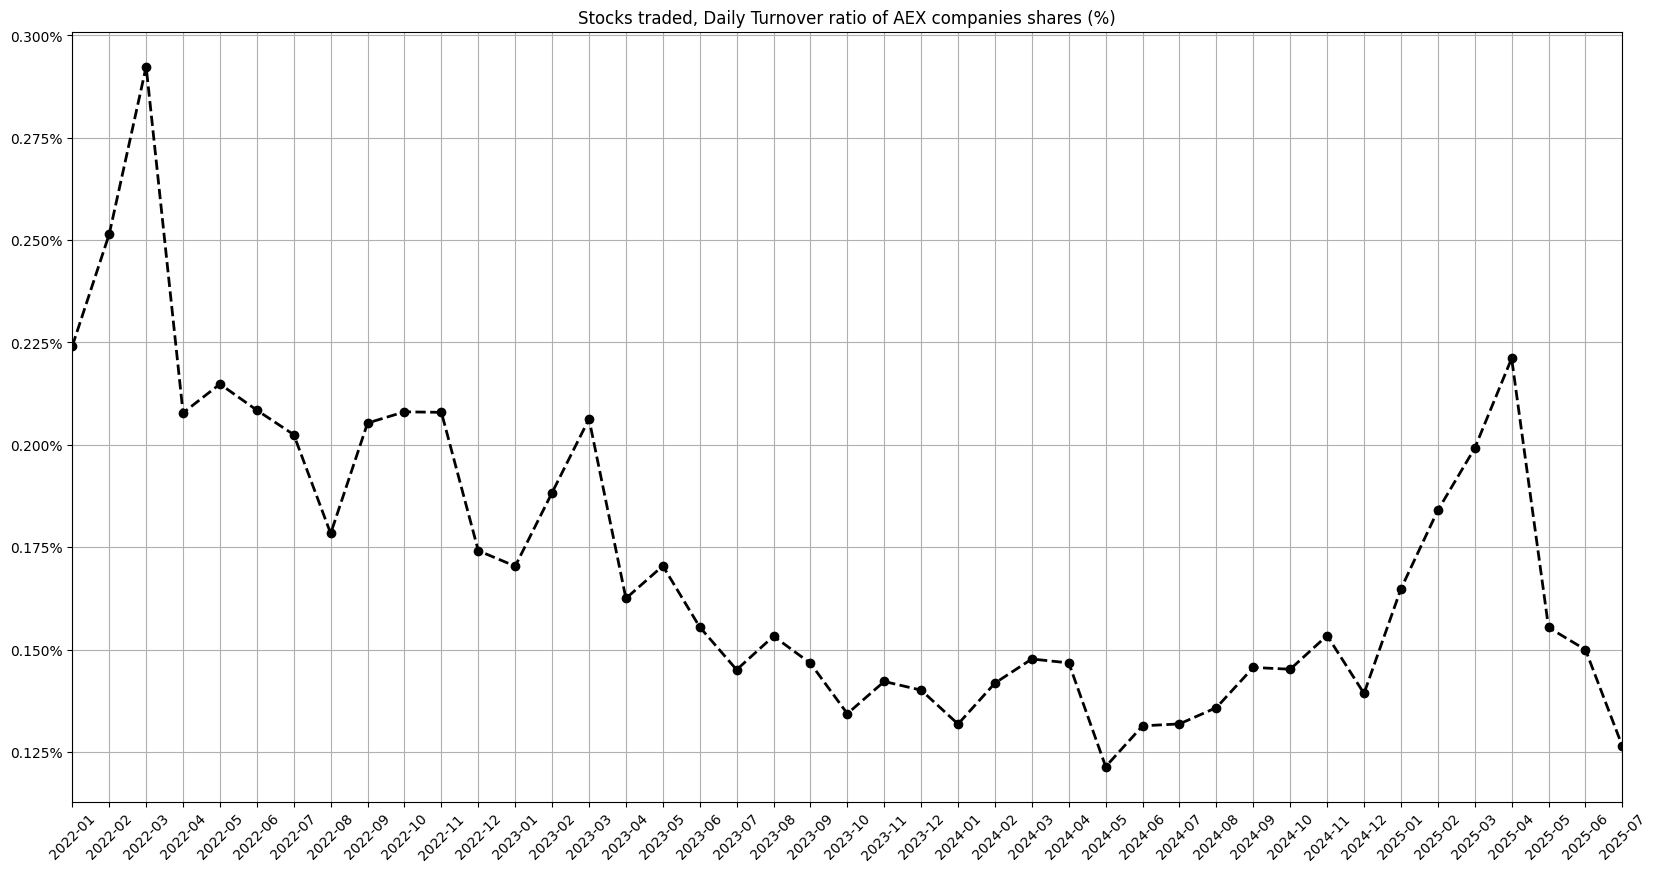

In [23]:
ax = aex_daily_turnover.plot(figsize=(20,10), grid=True,
                             title=TUROVER_RATIO_AEX_DAILY_GRAPH_TITLE, color='k', marker='o', linestyle='--',
                             linewidth=2, xticks=aex_daily_turnover.index, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, aex_daily_turnover.index)))

## Forward annual dividend yield of AEX companies

In [24]:
print(f'AEX companies forward dividend yield on {aex_metrics.data.index[-1]:%Y-%m-%d} is '
      f'{aex_metrics.forward_dividend_yield:.5}%')

AEX companies forward dividend yield on 2025-07-14 is 2.4967%


## Forward Price to Earnings ratio of AEX companies

In [25]:
print(f'AEX companies forward P/E on {aex_metrics.data.index[-1]:%Y-%m-%d} is '
      f'{aex_metrics.forward_PE:.2f}')

AEX companies forward P/E on 2025-07-14 is 15.69


## A sector breakdown for AEX
Understanding the sector breakdown of the AEX is key for investors, as it sheds light on the market’s exposure to different industries. Let’s examine the the current sector breakdown, based on the relative market capitalization of companies within each sector. Notably, the technology sector dominates with 28.68% of the total capitalization, as shown in the below chart.

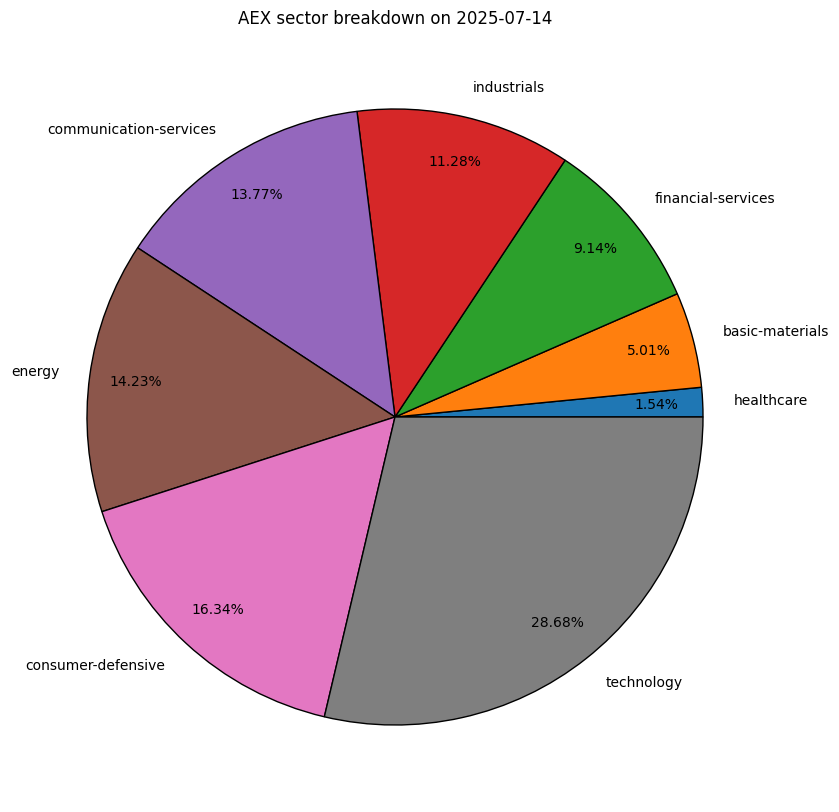

In [26]:
sector_bd = aex_metrics.get_sector_breakdown_for_day().sort_values()
ax = sector_bd.plot.pie(
    figsize=(20,10), grid=True, ylabel='',
    autopct=lambda pct: f'{pct:.2f}%', pctdistance=0.85,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1},
    title=f'AEX sector breakdown on {aex_metrics.data.index[-1]:%Y-%m-%d}')

## Year to date changes in capitalization (companies that gained)

In [94]:
from pandas.tseries.offsets import BYearBegin, BDay

cap_today = aex_metrics.get_top_n_capitalization_companies_for_day(25)
cap_year_start = aex_metrics.get_top_n_capitalization_companies_for_day(25, YearBegin(0).rollback(date.today()) + BDay(1))

In [95]:
ytd_pct_chg = ((cap_today.Capitalization - cap_year_start.Capitalization)/cap_year_start.Capitalization).sort_values(ascending=False)

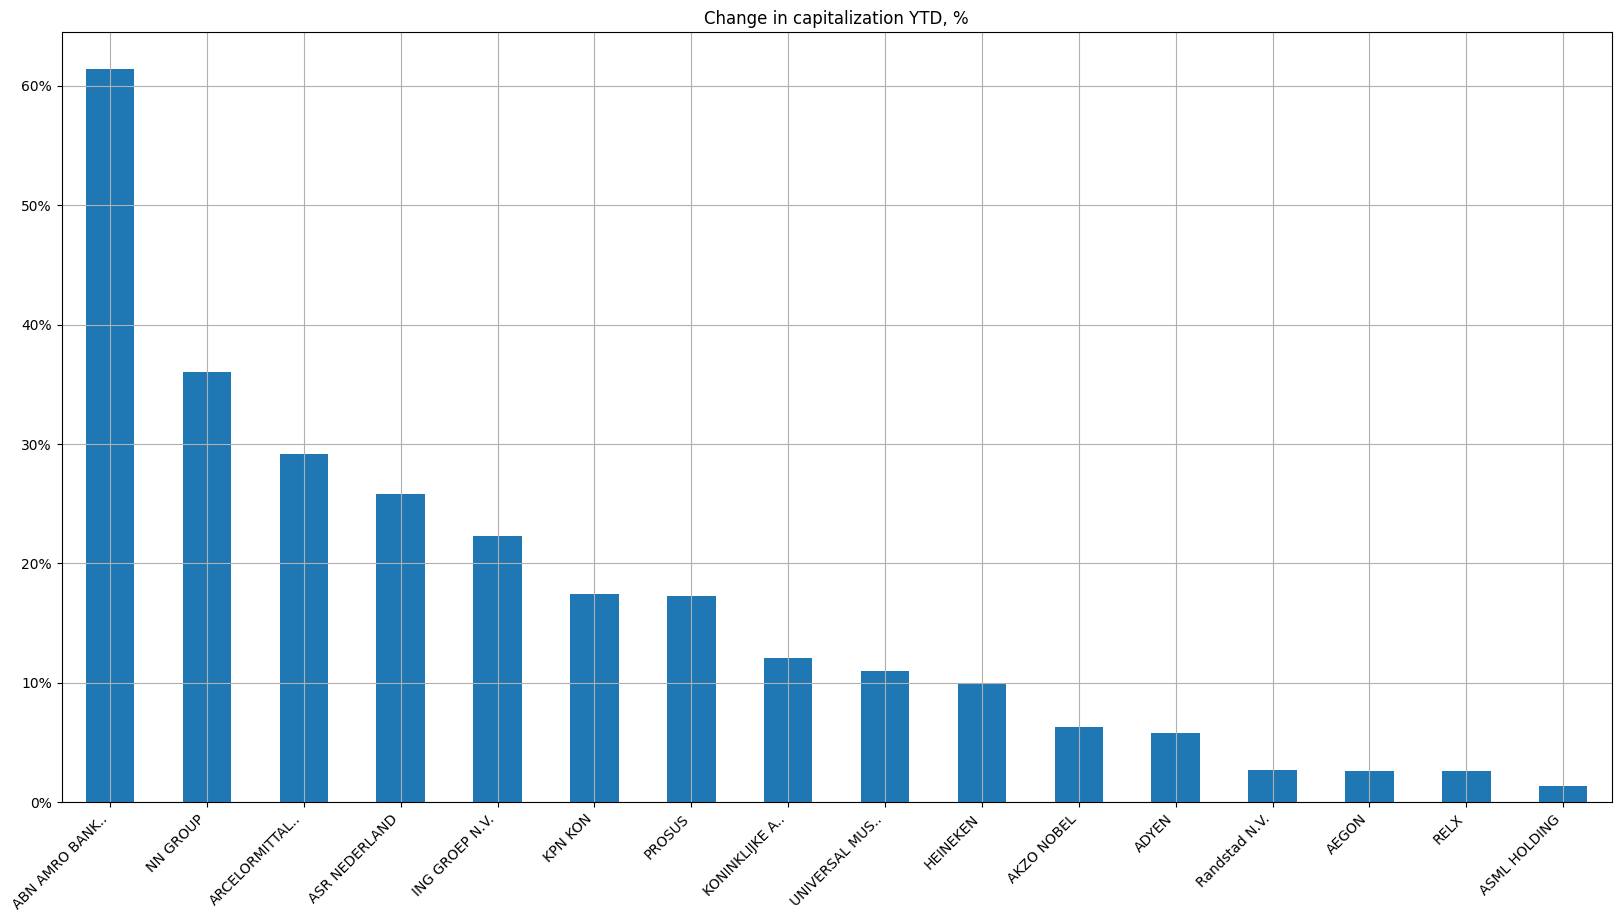

In [107]:
ax = ytd_pct_chg.loc[ytd_pct_chg > 0].plot.bar(figsize=(20,10), grid=True, title='Change in capitalization YTD, %',
                                    rot=45)
ax.yaxis.set_major_formatter('{x:,.0%}')
# Get tickers from your bar chart
tickers = ytd_pct_chg.loc[ytd_pct_chg > 0].index  # assuming index holds tickers

# Map tickers to company names
new_labels = [ticker_to_name.get(ticker, ticker) for ticker in tickers]

# Set custom x-axis labels
ax.set_xticks(range(len(new_labels)))
_ = ax.set_xticklabels(new_labels, rotation=45, ha="right")

In [96]:
ytd_pct_chg

ABN.AS      61.42%
NN.AS       36.04%
MT.AS       29.17%
ASRNL.AS    25.80%
INGA.AS     22.26%
KPN.AS      17.40%
PRX.AS      17.25%
AD.AS       12.10%
UMG.AS      10.98%
HEIA.AS      9.89%
AKZA.AS      6.29%
ADYEN.AS     5.78%
RAND.AS      2.68%
AGN.AS       2.63%
REN.AS       2.58%
ASML.AS      1.36%
SHELL.AS    -4.47%
UNA.AS      -5.40%
EXO.AS      -7.19%
BESI.AS     -8.91%
ASM.AS      -9.19%
DSFIR.AS    -9.24%
WKL.AS     -14.73%
PHIA.AS    -15.55%
IMCD.AS    -20.62%
Name: Capitalization, dtype: float64

In [101]:
ticker_to_name

{'ABN.AS': 'ABN AMRO BANK..',
 'ADYEN.AS': 'ADYEN',
 'AGN.AS': 'AEGON',
 'AD.AS': 'KONINKLIJKE A..',
 'AKZA.AS': 'AKZO NOBEL',
 'MT.AS': 'ARCELORMITTAL..',
 'ASM.AS': 'ASM Internati..',
 'ASML.AS': 'ASML HOLDING',
 'ASRNL.AS': 'ASR NEDERLAND',
 'BESI.AS': 'BE Semiconduc..',
 'DSFIR.AS': 'DSM FIRMENICH..',
 'EXO.AS': 'EXOR',
 'HEIA.AS': 'HEINEKEN',
 'IMCD.AS': 'IMCD',
 'INGA.AS': 'ING GROEP N.V.',
 'KPN.AS': 'KPN KON',
 'NN.AS': 'NN GROUP',
 'PHIA.AS': 'KON.PHILIPS N..',
 'PRX.AS': 'PROSUS',
 'RAND.AS': 'Randstad N.V.',
 'REN.AS': 'RELX',
 'SHELL.AS': 'SHELL PLC',
 'UMG.AS': 'UNIVERSAL MUS..',
 'UNA.AS': 'UNILEVER PLC',
 'WKL.AS': 'WOLTERS KLUWER',
 'LIGHT.AS': 'SIGNIFY NV',
 'URW.PA': 'UNIBAIL-RODAM..',
 'TKWY.AS': 'JUST EAT TAKE..'}